# Create Cossmic Grid

**Author:** Manuela Linke, HTWG Konstanz 

**Date:** 14.04.2024 

**Summary:** This script creates a power grid in pandapower format from .csv-Files containing the necessary informations.

For smooth operation the input files must must be naimed uniformly, following the example of the "cossmic grid".
Notice: if a line has two switches, they are combined to one.

TO USE THE SCRIPT YOU NEED TO ADAPT MANUALLY: 
* src_folder: source folder containing the input files
* grid_name: the name of the grid

INPUT FILES:
* buses_file: buses in the grid. Attributes: name, v_nom (kV), x, y, control
* lines_file: lines in the grid. Attributes: name, bus0, bus1, type, length (km), v_nom (kV), parallel   
* transformers_file: transformers. Attributes: name, bus0, bus1, type, s_nom (MVA)   
* switches_file: switch positions. Attributes: bus, element, et (l / t), closed (boolean, False = open, True = closed)
    
OPTIONAL INPUT:
* loads_file: loads in the grid for testing. Attributes: name, bus p_set (MW), p_max (MW)
* generations_file: generations in the grid for testing. Attributes: name, bus p_set (MW), p_max (MW) Static generators should always have a positive p_mw value, since all power values are given in the consumer system

<img src="../doc/img/Cossmic_grid_EN-1.png" alt="Cossmic Grid" width="600" height="400"/>

## Tell me the source folder location and the name of the grid

In [1]:
import os

src_folder =  os.path.join('Cossmic_grid', 'grid-data')
grid_name =  os.path.join('', 'cossmic_grid')

In [24]:
import pandas as pd
import pandapower as pp
from numpy import unique as unique
import os
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Load input files

In [3]:
buses = pd.read_table(src_folder + "/buses.csv", sep=",")
lines = pd.read_table(src_folder + "/lines.csv", sep=",")
transformers = pd.read_table(src_folder + "/transformers.csv", sep = ",")
switches = pd.read_table(src_folder + "/switches.csv", sep=",")

try:
    loads = pd.read_table(src_folder + "/loads.csv", sep=",")
except FileNotFoundError:
    loads = None
try:
    gens = pd.read_table(src_folder + "/generations.csv", sep=",")
except FileNotFoundError:
    gens = None

## Create empty grid

In [4]:
net = pp.create_empty_network()

In [5]:
net

This pandapower network is empty

## Create buses

In [6]:
for index, row in buses.iterrows():
    bus_created = pp.create_bus(net,
                          vn_kv=float(row['v_nom']),
                          name=row['name'], 
                          geodata=(row['y'],-row['x']))
    if row['control'] == "Slack":
        pp.create_ext_grid(net, bus=bus_created, vm_pu=1.0, name=row['name'])

In [7]:
net.bus

,name,vn_kv,type,zone,in_service
0,ind_1,0.4,b,None,True
1,ind_2,0.4,b,None,True
2,ind_3,0.4,b,None,True
3,res_1,0.4,b,None,True
4,res_2,0.4,b,None,True
5,res_3,0.4,b,None,True
6,res_4,0.4,b,None,True
7,res_5,0.4,b,None,True
8,res_6,0.4,b,None,True
9,pub_1,0.4,b,None,True


## Create lines

In [8]:
for index, row in lines.iterrows():
    bus0 = pp.get_element_index(net, "bus", row.bus0)
    bus1 = pp.get_element_index(net, "bus", row.bus1)
    pp.create_line(net, 
                   from_bus=bus0, 
                   to_bus=bus1, 
                   length_km=row['length'],
                   std_type=row['type'],
                   name=str(row['name']),
                   parallel=row['parallel'])  

In [9]:
#net.line

## Create transformers

In [10]:
for index, row in transformers.iterrows():
    mv_bus = pp.get_element_index(net, "bus", row.bus0)
    lv_bus = pp.get_element_index(net, "bus", row.bus1)
    pp.create_transformer(net, hv_bus=mv_bus, lv_bus=lv_bus, std_type=row['type'], name=str(row['name']))

C:\Users\mlinke\AppData\Local\anaconda3\envs\cnn_regler\lib\site-packages\pandapower\create.py:2666: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  net.trafo.tap_phase_shifter.fillna(False, inplace=True)
C:\Users\mlinke\AppData\Local\anaconda3\envs\cnn_regler\lib\site-packages\pandapower\create.py:2666: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermedia

In [11]:
net.trafo

,name,std_type,hv_bus,lv_bus,sn_mva,vn_hv_kv,vn_lv_kv,vk_percent,vkr_percent,pfe_kw,i0_percent,shift_degree,tap_side,tap_neutral,tap_min,tap_max,tap_step_percent,tap_step_degree,tap_pos,tap_phase_shifter,parallel,df,in_service
0,trafo_400kVA,0.4 MVA 10/0.4 kV,11,8,0.40,10.0,0.4,4.0,1.3250,0.95,0.2375,150.0,hv,0,-2,2,2.5,0.0,0,False,1,1.0,True
1,trafo_630kVA,0.63 MVA 10/0.4 kV,12,1,0.63,10.0,0.4,4.0,1.0794,1.18,0.1873,150.0,hv,0,-2,2,2.5,0.0,0,False,1,1.0,True


### Create switches 

In [12]:
for index, row in switches.iterrows():
    bus = pp.get_element_index(net, "bus", row.bus)
    et = str(row['et'])
    closed = bool(row['closed'])
    if et == 'l' :  
        element = pp.get_element_index(net, "line", row.element)
    else :
        element = pp.get_element_index(net, "trafo", row.element)
    pp.create_switch(net, 
                     bus=bus, 
                     element=element, 
                     et=et,
                     closed=closed)

## Create loads and generations
if loads_file and or generations file exists


In [13]:
if loads is not None:
    for index, row in loads.iterrows():
        bus = pp.get_element_index(net, "bus", row.bus)
        pp.create_load(net, bus=bus, p_mw=row['p_max'], name=row['name'])

In [14]:
if gens is not None:
    for index, row in loads.iterrows():
        bus = pp.get_element_index(net, "bus", row.bus)
        pp.create_gen(net, bus=bus, p_mw=row['p_max'], name=row['name'])

In [15]:
net.load

,name,bus,p_mw,q_mvar,const_z_percent,const_i_percent,sn_mva,scaling,in_service,type
0,ind_1,0,0.1630,0.0,0.0,0.0,NaN,1.0,True,wye
1,ind_2,1,0.0112,0.0,0.0,0.0,NaN,1.0,True,wye
2,ind_3,2,0.2560,0.0,0.0,0.0,NaN,1.0,True,wye
3,res_1,3,0.0067,0.0,0.0,0.0,NaN,1.0,True,wye
4,res_2,4,0.0081,0.0,0.0,0.0,NaN,1.0,True,wye
5,res_3,5,0.0052,0.0,0.0,0.0,NaN,1.0,True,wye
6,res_4,6,0.0058,0.0,0.0,0.0,NaN,1.0,True,wye
7,res_5,7,0.0037,0.0,0.0,0.0,NaN,1.0,True,wye
8,res_6,8,0.0035,0.0,0.0,0.0,NaN,1.0,True,wye
9,pub_1,9,0.0200,0.0,0.0,0.0,NaN,1.0,True,wye


## unconnected node search

In [16]:
if len(pp.topology.unsupplied_buses(net)) == 0:
    print("All busses supplied")
else:
    print("Topology problem: node(s) " + str(pp.topology.unsupplied_buses(net)) + " unsupplied!")

All busses supplied


## Test: power flow simulation if loads-file exists

In [17]:
if loads is not None:
    pp.runpp(net)

In [18]:
net

This pandapower network includes the following parameter tables:
   - bus (13 element)
   - load (11 element)
   - switch (14 element)
   - ext_grid (2 element)
   - line (12 element)
   - trafo (2 element)
   - bus_geodata (13 element)
 and the following results tables:
   - res_bus (13 element)
   - res_line (12 element)
   - res_trafo (2 element)
   - res_ext_grid (2 element)
   - res_load (11 element)
   - res_switch (14 element)

## Plotting the network

In [21]:
import matplotlib.pyplot as plt
import pandapower.plotting as plot
from math import pi

def plot_grid(net, save=False, filename='foo'):
    """
    Plots a pandapower network as diagram.
    INPUT:
        **net** - The pandapower format network.
    OPTIONAL:
        **save** (bool, False) - save the plot.
        **filename** (String, 'foo') - filename for saving the plot.
    """    
    tie_lines = set(net.switch.element[~net.switch.closed.values].values)
    lines = set(net.line.index) - tie_lines

    #plot buses
    bc = plot.create_bus_collection(net, size=.04, zorder=10, color="b")

    #plot lines and switches
    lc = plot.create_line_collection(net, lines, linewidths=3., use_bus_geodata=True, color="k")
    olr = plot.create_line_collection(net, lines=tie_lines, color='k', linewidths=2.0,
                                      use_bus_geodata=True, linestyles="dashed")
    sc = plot.create_line_switch_collection(net, size=0.1, distance_to_bus=.12, use_line_geodata=True,
                                            zorder=12, color="k")

    #plot transformers
    t31, t32 = plot.create_trafo3w_collection(net, linewidths=2.)
    t21, t22 = plot.create_trafo_collection(net, linewidths=2.)

    #plot load and generation elements
    orient = [-pi/2 if i==2 else pi for i in range(len(net.load))]
    lc1, lc2 = plot.create_load_collection(net, size=0.1, orientation=orient, linewidths=2.)
    #sc1, sc2 = plot.create_sgen_collection(net, size=0.12, orientation=2*pi, linewidths=1.)
    sl1, sl2 = plot.create_ext_grid_collection(net, size=0.4, orientation=-3*pi/2, linewidths=2.)
    plot.draw_collections([bc, lc, olr, lc1, lc2, sc, t21, t22, t31, t32, sl1, sl2], figsize=(9,4))
    
    if save == True:
        plt.savefig(filename + '.png', bbox_inches='tight')
    #ax = draw_collections(collections, ax=ax)
    plt.show()

8 in collections is of unknown type. Skipping
9 in collections is of unknown type. Skipping


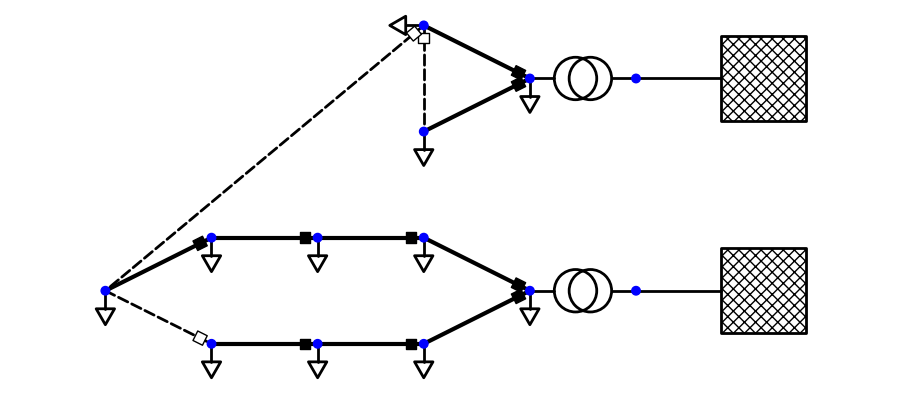

In [22]:
plot_grid(net, save = True, filename = 'cossmic_grid')

## Save network

In [23]:
import os
pp.to_pickle(net, grid_name + ".p")